# Perception by dealing with Computer Vision
It's very important for robotics perception. Robot can be broken down into three essential step cycle.
    
    Perception >> Dicision >> Action
    
This notebook related with first step, **Perception**. For the task of perception we can use data from some kind of sensors like Lidor, Razor and Camera. The table of bellow compare some sensors. Here I use camera as eye ball for perception. 

    -----------------------------------------------------------------------------
    |     Sensor    ||    Spartial Resolution    |    Dimension    |    Cost    |
    |===============||===========================|=================|============|
    | Lidor + Razor ||           Low             |       3D        |  Expensive |
    |     Camera    ||           High            |       2D        |    Chea    |
    -----------------------------------------------------------------------------
Computer vision is art and science to percieving and understanding the world around us through images. In self driving cars it helps us to detect lane marking, other cars and pedestrians and so on to navigate safely our cars.

## Distortion Correction
##### Overview
Measure some of the quantities that need to be known in order to control the car. For example to steer car we need to measure how much your lane is curving. To do that I need to map out the lanes in my camera image, after transforming them to a different perspective. One way we are looking down on the road from above. In order to get this perspective transformation right, I first have to correct for the effect of image distortion.
Cameras don't create perfect images. Some of the object in the images, especially ones near the edges, can get stretched or skewed in various ways. So I need to correct distortions.

#####  What is Distortion? Why we need to undo distortions?
When a camera looks at 3D objects in the real world and transforms them into a 2D image. This transformation isn't perfect. Distortion is actuarry changing what the shape and size of these objects appears to be and closer or farther away than they actuarry are. This is a problem, because we're trying to accurately place the self-driving car in this world.

##### Types of Distortion
 - Radial Distortion(Introduced by camera lense)
 - Tangental Distortion(Introduced by not aligned perfectly parallel the camera's lens with the imaging plane)
 
##### Distortion Coefficitnts
Distortion can generally be captured by five numbers called distortion coefficients, whose values reflect the amount of radial and tangental distortion in an image. We can use them to calibrate our camera and undistort our images.

    Distortion coefficients = (k1, k2, p1, p2, k3)
In severely distorted cases, sometimes even more than five coefficients are required to capture the amount of distortion.

##### Math for Distortion Correction
To correct for **radial distortion** => **k1**, **k2**, and **k3**.
 - (x,y) is a point in a distorted image.
 - **r** which is calculated by OpenCV is the known distance between a point in an undistorted(corrected) image(xcorrected,ycorrected) and the center of the image distortion (xc, yc) as the distortion center.

Note: The distortion coefficient k3 is required to accurately reflect major radial distortion (like in wide angle lenses). However, for minor radial distortion, which most regular camera lenses have, k3 has a value close to or equal to zero and is negligible. So, in OpenCV, you can choose to ignore this coefficient; this is why it appears at the end of the distortion values array: [k1, k2, p1, p2, k3].

 - x_distorted = x_ideal(1 + k1 * r^2 + k2 * r^4 + k3 * r^6)
 - y_distorted = y_ideal(1 + k1 * r^2 + k2 * r^4 + k3 * r^6)

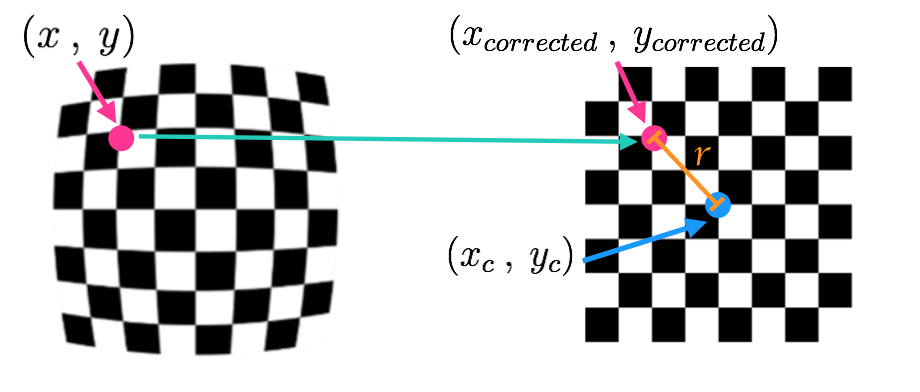
(image from Udacity)


To correct for **tangental distortion** => **p1**, **p2**.
 - x_corrected = x + [2p1xy + p2(r^2 + 2x^2)]
 - y_corrected = y + [p1(r^2 + 2y^2) + 2p2xy]


## Finding Corners
 - findChessboardCorners()
    The function attempts to determine wheather the input image is a view of the chessboard pattern and lokate the internal chessboard corners.
 - drawChessboardCorners()
    Renders the detected chessboard corners
---
**findChessboardCorners()**
##### Parameters
 - p1: source image of chessboard(must be an 8-bit grayscale or color image)
 - p2: patternSize the number of inner corners per a chessboard row and column
 - p3: corners which is output array of detected corners
 - p4: flags which can be zero or a combination of the following values
 
##### Returns
 - r1: 'true' if all of the corners are found and they are placed in a certain order. Otherwise, if the function fails to find all the corners or reorder them, it returns 'false'.
  - r2: corners the point of coordinate(x,y) detected
 
---
**drawChessboardCorners()**
##### Parameters
 - p1: image which is destination image.
 - p2: patternSize which is number of inner corners per a chessboard row and column
 - p3: corners which is output of findChessboardCorners()
 - p4: patternWasFound which is output of findChessboardCorners() for indicating wheather the complete board was found or not.
 
##### Returns
 - None

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fname = 'calibration_test.png'
img = cv2.imread(fname)
origin = np.copy(img)

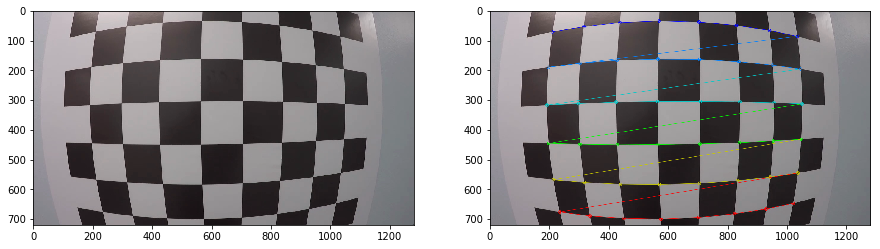

In [2]:
nx = 8
ny = 6

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

if ret == True:
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    fig = plt.figure(figsize=(15, 30))
    ax1 = fig.add_subplot(1,2,1)
    ax1.imshow(origin)
    ax2 = fig.add_subplot(1,2,2)
    ax2.imshow(img)
    plt.show()

## Calibrating a Camera
The first step will be to read in calibration images of a chessboard. It's recommended to use at least 20 images to ge a reliable calibration. Those images are taken at different angles and distances. 

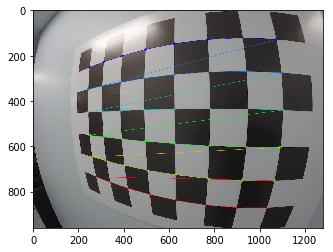

In [15]:
import glob

images = glob.glob('calibration_wide/GOPR*.jpg')
idx = 4
img = cv2.imread(images[idx])
origin = np.copy(img)

objpoints = [] # 3D points in real world space (x,y,z)
imgpoints = [] # 2D points in image plane (x,y)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0),...,(6,4,0)
objp = np.zeros((6*8, 3), np.float32)
objp[:,:2] = np.mgrid[0:8, 0:6].T.reshape((-1,2))

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, corners = cv2.findChessboardCorners(gray, (8, 6), None)

if ret == True:
    img = cv2.drawChessboardCorners(img, (8,6), corners, ret)
    objpoints.append(objp)
    imgpoints.append(corners)
    plt.imshow(img)

---
**calibrateCamera()**

##### Parameters
 - p1: objectPoints which is the 3D points in real world space.
 - p2: imagePoints which is the 2D points in image plane
 - p3: the shape of the image

##### Returns
 - r1: ret
 - r2: the camera matrix that we need to transform 3D object points to 2D image points
 - r3: distortion coefficients
 - r4: rotation vectors
 - r5: translation vectors

In [16]:
def cal_undistort(img, objpoints, imgpoints):
    ret, cmtx, distCoef, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)
    undist = cv2.undistort(img, cmtx, distCoef)
    return undist

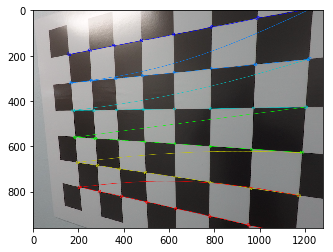

In [18]:
undistorted = cal_undistort(img, objpoints, imgpoints)
plt.imshow(undistorted)

## Correcting for Distortion
**undistort()**
##### Parameters
 - p1: distorted image
 - p2: camera matrix
 - p3: distortion coefficients

##### Returns
 - r1: undistorted image often called "dst"

## Perspective Transform